In [80]:
import pandas as pd
import temporian as tp
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import ydf

pd.options.mode.chained_assignment = None
tp.config.display_max_indexes = 3
tp.config.display_max_events = 4

## Part 3: Decision Forests Forecasting

In the previous part, we used statistical forecasting methods to predict the future values of a time-series given its past values. Statistical forecasting methods are sample-efficient, meaning they don't need a lot of data to get results. However, if you have a lot of data, their don't always benefit from it. Instead, when lot of data is available, more powerful machine learning methods can lean more complex patterns and make better forecasts.

In this part, we replace statistical forecasting methods with decision forests (DF) models. DFs are easy and fast to train, making they suitable for prototyping and learning about methods. They also show good results and provide partial interpretable, so they are worth knowing.

In the previous parts, the setup was relatively simple. However, in many real-world applications, the setup is more complex. For instance:

- Multiple variables or interests may be involved.
- The data is not sampled uniformly. Different variables are sampled differently.
- Not all values are numerical; e.g. some may be categorical, free text, or images.
- Complex relationships and hierarchical structures may exist between different types of entities.
- Exogenous variables (variables of indirect interest known in advance, such as holidays) may be present.
- Endogenous variables (variables of indirect interest not known in advance, such as oil prices) may be present.
To illustrate this complexity, we will use the Makridakis Forecasting Competition M5 dataset.
- Features require cleaning, preprocessing and data-augmentation before being consumed by a model.

To illustrates all those points, we will use another dataset.

## The data: The M5 Competition

The [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview) is the 2020 instance of the [Makridakis Forecasting Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions). The objective of this competition is to forecast the next 28 days of sales of 3k individual items in 10 different Walmart stores.
Walmart's data has a strong hierarchical structure, since each item belongs to a certain category and department, and each store to a certain state.
This means that, besides the 30k individual low-level time series corresponding to the daily sales of a specific item in a specific store (which we'll be referring to as an "item-store" or "level 12" time series), the data can be aggregated in multiple ways to generate a total of 42,840 time series to be forecasted, as shown in the images below.

In this notebook, we will stick to only predicting the sales of item-store series, though the data's hierarchical structure will come in handy in the feature engineering stage.

Details such as the [competition's guide](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf) and [Makridakis' analysis of the winning entries](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions) are available online.

In [2]:
!ls -lh datasets/m5

total 430M
-rw-r----- 1 gbm primarygroup 102K May 28 16:01 calendar.csv
-rw-r----- 1 gbm primarygroup 117M May 28 16:01 sales_train_evaluation.csv
-rw-r----- 1 gbm primarygroup 115M May 28 16:01 sales_train_validation.csv
-rw-r----- 1 gbm primarygroup 5.0M May 28 16:01 sample_submission.csv
-rw-r----- 1 gbm primarygroup 194M May 28 16:01 sell_prices.csv


The dataset is composed of 5 csv files:

- `sales_train_evaluation`: The history of item sales.
- `calendar.csv`: Dates and calendar events related to the sales.
- `sell_prices.csv`: The history of the item prices. **Not used in this tutorial.**
- `sales_train_validation`: Another set of sales. **Not used in this tutorial.**
- `sample_submission`: An example of submission for the competition. **Not used in this tutorial.**

Let's load and take a look at the historical sales in  `sales_train_evaluation.csv`. Each row contains the sales of a item+store pair (i.e. for a given item in a given store). Sales are aggregated per day. Each day, indexed between 1 and 1914 (5+ years), is stored in a different column.

In [3]:
raw_sales = pd.read_csv("datasets/m5/sales_train_evaluation.csv")
print("First 5 rows")
raw_sales.head()

First 5 rows


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


Let's look at the sales of the first rows.

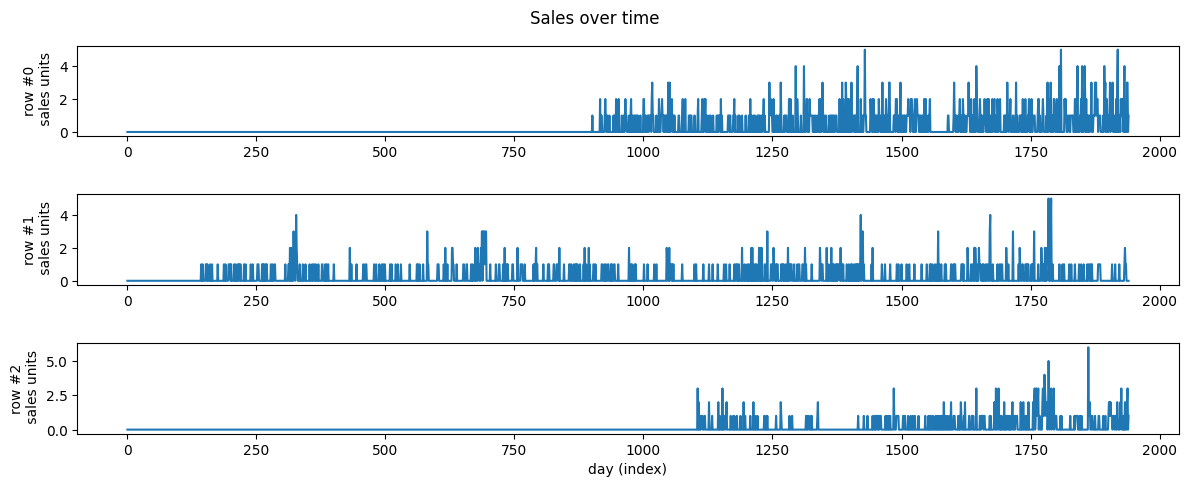

In [4]:
#@title
num_plots = 3
plt.figure(figsize=(12,2 * num_plots))
d_cols = list(raw_sales.filter(regex="d_"))

for row_idx in range(num_plots):
  sales_ts = raw_sales.iloc[row_idx][d_cols].to_numpy()
  plt.subplot(num_plots+1, 1, row_idx+1)
  plt.plot(sales_ts)
  plt.ylabel(f"row #{row_idx}\n sales units")

plt.suptitle("Sales over time")
plt.xlabel("day (index)")
plt.tight_layout()
plt.show()

### Question

1. What insights or conclusions do you draw from the plots above?

In [5]:
#@title Solution

# 1. Not all products started being sold at the same time. They usually start with 0 sales units.
# 2. Row #0, #1 and #3 show really different pattern. Row #0 and #2 look quite irregular. Row #1 shows some peaks every 365 days approx.
# 3. Row #2 show a period, which seems to be an out-of-stock period, between day 1250 and 1500.
# 4. Sales seem very sporadic for row #1, with several periods of 0 sales.
# 5. any others?

The sales are organized in two hierarchies: products/departments/category and store/state. We can predict the sales of each product in isolations, the forecasts will be better is information is allowed to "flow" though the hierarchy. For instance, some products in similar or different departments might have related sales (such as diapers and beer).

In the previous part, we used hierarchical reconciliation to make hierarchy aware forecasts: Individual models were trained for each time-series (product in the M5 dataset) and their forecasting were normalized together. In this part, we will use a global model: We will train a single model with access to the hierarchy. The model is free to use or ignore the hierarchy.

To make the execution of the tutorial faster and more interesting, we downsample the dataset. We focus on a subset of 8 food products with the largest sale counts.

In [6]:
if True: # Optional downsampling of the dataset.
    
    # The items with the most sales.
    selected_items_names = ['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252', 'FOODS_3_555',
                            'FOODS_3_587', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226',
                            #'FOODS_3_202', 'FOODS_3_120', 'FOODS_3_723', 'FOODS_3_635',
                            #'FOODS_3_808', 'FOODS_3_377', 'FOODS_3_541', 'FOODS_3_080',
                            #'FOODS_3_318', 'FOODS_2_360', 'FOODS_3_681', 'FOODS_3_234',
                           ]
    raw_sales = raw_sales[raw_sales["item_id"].isin(selected_items_names)]
    print("Number of time series:", len(raw_sales))

Number of time series: 80


Let's load calendar events. Those are known in advanced calendar events that might have impact on sales. For example, father's day of the NBA Finals might impact purchases.

This table is complementary to other possibly impactful calendar data such as the day of the week or month of the year.

In [7]:
raw_calendar = pd.read_csv("datasets/m5/calendar.csv")
raw_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


## Normalize dataset

The tables `sales_raw` and `calendar_raw` represents temporal data in a different way. For example, timestamps are stored by columns in `sales_raw` and by rows in `calendar_raw`. The two tables also use a different system to represent dates.

To prepare, preprocess and augment the data, we use the Pandas and Temporian. Pandas allows to general options on tabular data (called "dataframes") while Temporian is specialized for temporal data processing.
Let's normalize all the the raw tables in the same format.

### Normalize sales

Each sales value is stored in a different column. Instead, we want for each value (which in Temporian we refer to as an event) to be in a different row.

For example, the record:

```
id,item_id,dept_id,d_1,d_2,d_3,...,d_n
```

will be converted to the following records:

```
id,item_id,dept_id,day,d_1
id,item_id,dept_id,day,d_2
...
id,item_id,dept_id,day,d_n
```

In [8]:
sales = pd.melt(
    raw_sales,
    var_name="day",
    value_name="sales",
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
)
sales["day"] = sales["day"].apply(lambda x: int(x[2:]))
del sales["id"] # Remove id
sales

,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1,107
1,FOODS_3_226,FOODS_3,FOODS,CA_1,CA,1,13
2,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,1,19
3,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,1,23
4,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,1,42
...,...,...,...,...,...,...,...
155275,FOODS_3_555,FOODS_3,FOODS,WI_3,WI,1941,39
155276,FOODS_3_586,FOODS_3,FOODS,WI_3,WI,1941,37
155277,FOODS_3_587,FOODS_3,FOODS,WI_3,WI,1941,24
155278,FOODS_3_694,FOODS_3,FOODS,WI_3,WI,1941,48


The timestamps are expressed in number of days since `29/1/2011`.
Let's convert them into python datetimes.

In [9]:
origin_date = datetime(2011, 1, 29, tzinfo=timezone.utc)
sales["timestamp"] = sales["day"].apply(
    lambda x: (origin_date + timedelta(days=x - 1))
)
del sales["day"]
sales

,item_id,dept_id,cat_id,store_id,state_id,sales,timestamp
0,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,107,2011-01-29 00:00:00+00:00
1,FOODS_3_226,FOODS_3,FOODS,CA_1,CA,13,2011-01-29 00:00:00+00:00
2,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,19,2011-01-29 00:00:00+00:00
3,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,23,2011-01-29 00:00:00+00:00
4,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,42,2011-01-29 00:00:00+00:00
...,...,...,...,...,...,...,...
155275,FOODS_3_555,FOODS_3,FOODS,WI_3,WI,39,2016-05-22 00:00:00+00:00
155276,FOODS_3_586,FOODS_3,FOODS,WI_3,WI,37,2016-05-22 00:00:00+00:00
155277,FOODS_3_587,FOODS_3,FOODS,WI_3,WI,24,2016-05-22 00:00:00+00:00
155278,FOODS_3_694,FOODS_3,FOODS,WI_3,WI,48,2016-05-22 00:00:00+00:00


Let's now convert `sales` from a Pandas DataFrame to a Temporian EventSet.

In [10]:
sales = tp.from_pandas(
    sales,
    indexes=["item_id", "dept_id", "cat_id", "store_id", "state_id"],
)
sales

timestamp,sales
2011-01-29 00:00:00+00:00,107
2011-01-30 00:00:00+00:00,182
2011-01-31 00:00:00+00:00,47
…,…
2016-05-20 00:00:00+00:00,69
2016-05-21 00:00:00+00:00,67
2016-05-22 00:00:00+00:00,64
timestamp,sales
2011-01-29 00:00:00+00:00,116
2011-01-30 00:00:00+00:00,90


Let's plot the sales of the first two products.

In [11]:
sales.plot(max_num_plots=4, interactive=True)

Note that `sales` is indexed by product/department/category/store and state.

### Normalize `raw_calendar`

In `raw_calendar`, timestamps are expressed as ISO 8601 string e.g., `2011-01-29`. Let's convert them into python datetimes.

In [12]:
calendar = raw_calendar.copy()

# Temporian and YDF (see later) treat NaN values as "missing".
# In this dataset, a NaN means that there is not calendar event on this day.
calendar.fillna("no_event", inplace=True)

calendar["timestamp"] = calendar["date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)

# We keep the mapping wm_yr_wk -> timestamp to clean "raw_sell_prices" in the next section.
wm_yr_wk_map = calendar[["weekday", "timestamp", "wm_yr_wk"]]

del calendar["date"]
del calendar["wm_yr_wk"]
del calendar["d"]
del calendar["weekday"]
del calendar["wday"]
del calendar["month"]
del calendar["year"]
calendar

,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,timestamp
0,no_event,no_event,no_event,no_event,0,0,0,2011-01-29
1,no_event,no_event,no_event,no_event,0,0,0,2011-01-30
2,no_event,no_event,no_event,no_event,0,0,0,2011-01-31
3,no_event,no_event,no_event,no_event,1,1,0,2011-02-01
4,no_event,no_event,no_event,no_event,1,0,1,2011-02-02
...,...,...,...,...,...,...,...,...
1964,no_event,no_event,no_event,no_event,0,1,1,2016-06-15
1965,no_event,no_event,no_event,no_event,0,0,0,2016-06-16
1966,no_event,no_event,no_event,no_event,0,0,0,2016-06-17
1967,no_event,no_event,no_event,no_event,0,0,0,2016-06-18


Same as before, we can convert the calendar data into a Temporian EventSet.


In [13]:
calendar = tp.from_pandas(calendar)
calendar

timestamp,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
2011-01-29 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2011-01-30 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2011-01-31 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
…,…,…,…,…,…,…,…
2016-06-17 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2016-06-18 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2016-06-19 00:00:00+00:00,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


Note that `calendar` is not indexed: All the events are global.

## Feature engineering

The methods shown in the previous parts were able to consume time series natively. However, generic tabular machine learning models such as decision forests are not. Instead, as the name suggest, those algorithm consume tables of data where each row is an independent observation.

We could feed each row of our dataset to the model, but it would not be that interesting: The model would be trained to predict the sales of day `t` using all the information available at day `t`. While possibly interesting, this is not much of a forecasting. Instead, we want to predict the sales at day `t+h` (`h>0`) using information available at day `t`. In other words, we want to predict some rows from other rows.

The simplest solution for that is to use feature preprocessing, and Temporian is specialized for that.

### Basic preprocessing : lagged sales

We have to choose what each row of the preprocessed dataset represents. A good convention which help avoiding future leakage in pipeline is to attache a timestamp to each row and enforce that the row only contains information available at it timestamp. For example, a row with timestamp `2022-09-12` can only contain data derived from observations at or anterior to `2022-09-12`. This include for example, the sum of all the sales in the last week (i.e. the sales from `2022-09-6` to `2022-09-12`).

This kind of summation, called moving sum, is a simple or powerful way to prepare data. This will be our first preprocessing.


In [14]:
lagged_sales_list : list[tp.EventSet] = []
for horizon in [1, 2, 3, 7, 14]:
    x = sales["sales"].lag(tp.duration.days(horizon))
    x = x.resample(sales)
    x = x.rename(f"f_sales_lag{horizon}")
    lagged_sales_list.append(x)
feature_lagged_sales = tp.glue(*lagged_sales_list)

The dataset is too large to be plotted. Instead, we will plot the preprocessing on a single randomly selected product and for a short period of time.

In [15]:
# Select a product.
selected_index = sales.get_arbitrary_index_key()
print("Selected product (selected_index):", selected_index)

Selected product (selected_index): (b'FOODS_3_694', b'FOODS_3', b'FOODS', b'WI_2', b'WI')


The number of plots (5) is larger than "options.max_num_plots=4". Only the first plots will be printed.


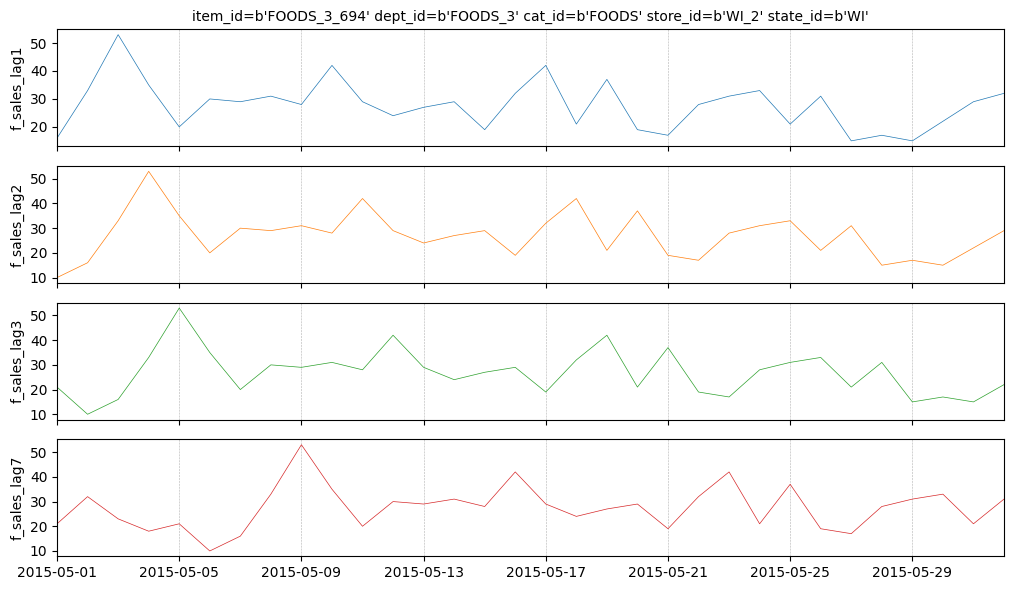

In [16]:
plot_options = {
    # Only plot the selected product.
    "indexes": selected_index,
    # Optional: Make the plot interactive.
    # "interactive": True,
    # Only plot the data for the year 2015.
    "min_time": datetime(2015, 5, 1),
    "max_time": datetime(2015, 6, 1),
}
feature_lagged_sales.plot(**plot_options, max_num_plots=4)

### Preparing labels

The label is the only column that does not follow the future leakage restriction of the features. This is actually the oppositive: Predicting the label should be a forecast, therefore labels at time `t` should tell us something about the future, such as the sales at the `t+1`.

Our goal in this tutorial is to forecast the sales for the next 28 individual days. Therefore, we create those 28 labels.

In [17]:
# Prediction horizon. In the M5 competition, participants should forecast the next 28 days.
# You can predict less days to make the training section of this notebook run faster.
horizons = list(range(1, 14))

# For each of the horizons.
label_list: list[tp.EventSet] = []
for horizon in horizons:
    # Leak the sales in the past.
    x = sales["sales"].leak(tp.duration.days(horizon))

    # Resample the label to the sales data.
    x = x.resample(sales)

    # Give a name to the label for book-keeping.
    x = x.rename(f"label_h{horizon}")
    label_list.append(x)

labels = tp.glue(*label_list)

Let's see what the labels look like. Can you see how they shift more and more to the left while the horizon increases?


The number of plots (13) is larger than "options.max_num_plots=4". Only the first plots will be printed.


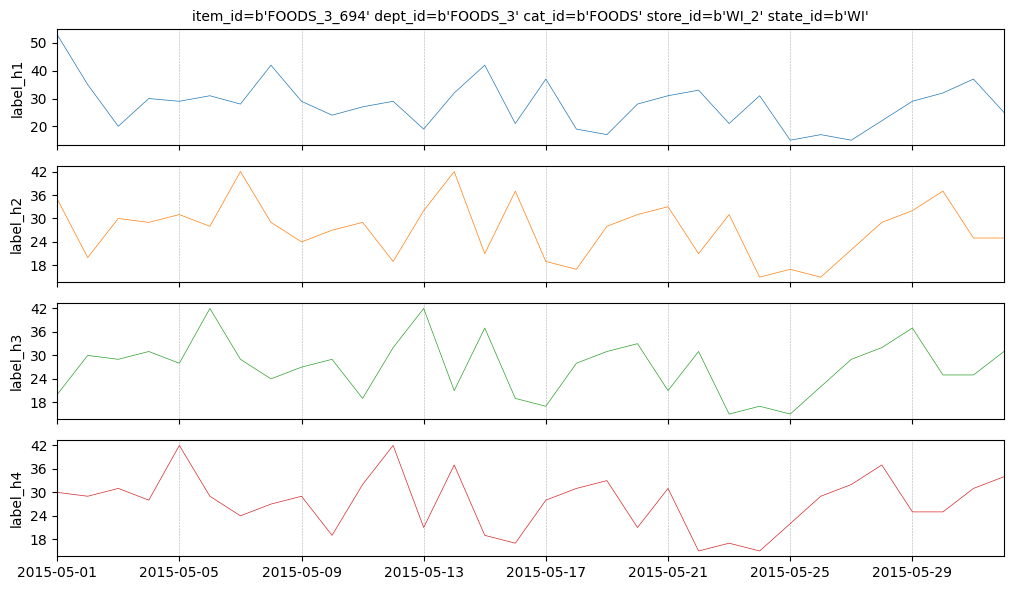

In [18]:
labels.plot(**plot_options, max_num_plots=4)

### Question

1. Can you see the "shift" of the label when h increases?
2. What would a shift in the other direction mean?

In [19]:
#@title Solution

# TODO

## Train and evaluate a first model

We can now train and evaluate our first model using only lagged sales as features.

We use a train and test protocol to evaluate our model. In classical tabular machine learning, train and test examples can be separated randomly. However, because of the time dependency between our rows, and because we want to apply our forecasting model in the future (and not in the past; we are not archeology), it is important for the training examples to be anterior to the test examples.

The dataset ranges from `2011-01-29` to `2016-06-19`. We will use the data in `2016` for testing, and interior data to training.

In [20]:
end_train_cutoff = datetime(2016, 1,1)

Our lagging feature dependency on sales in the last 14 days. Therefore, at the start of the dataset, this feature is not available. For example, on day `2011-01-29`, we have no sales records for 14 days before.

Therefore, we will start the training dataset on 2011-02-15`. Note that interior values will still be available though the lagging features.

In [21]:
start_train_cutoff = datetime(2011, 2,15)

Let's split the data.

In [22]:
def split_train_test(data : tp.EventSet):
    train_data = data.after(start_train_cutoff).before(end_train_cutoff)
    test_data = data.after(end_train_cutoff)
    return train_data, test_data

features_and_labels = tp.glue(feature_lagged_sales, labels)
train_examples, test_examples = split_train_test(features_and_labels)

print("Number of train examples:", train_examples.num_events())
print("Number of test examples:", test_examples.num_events())

Number of train examples: 142400
Number of test examples: 11360


We train a separate model for each of the labels and aggregate the predictions.

In [23]:
feature_names = feature_lagged_sales.schema.feature_names()
label_names = labels.schema.feature_names()

print("feature_names:", feature_names)
print("label_names:", label_names)

feature_names: ['f_sales_lag1', 'f_sales_lag2', 'f_sales_lag3', 'f_sales_lag7', 'f_sales_lag14']
label_names: ['label_h1', 'label_h2', 'label_h3', 'label_h4', 'label_h5', 'label_h6', 'label_h7', 'label_h8', 'label_h9', 'label_h10', 'label_h11', 'label_h12', 'label_h13']


In [24]:
models = []
for label_name in label_names:
    print(f"Train model for label {label_name!r}")

    # To train the model, we use YDF. YDF consumes natively Pandas dataframes so
    # we convert the Temporian EventSets into Pandas DataFrames before training.
    train_examples_df = tp.to_pandas(train_examples)

    # Configure the learning algorithm
    learner = ydf.GradientBoostedTreesLearner(
        task=ydf.Task.REGRESSION,
        label=label_name,
        num_trees=20,  # Increase the number of trees (e.g., 100) for a better model.
        features=feature_names,
    )

    # Train the model
    model = learner.train(train_examples_df)
    
    models.append(model)

Train model for label 'label_h1'
Train model on 142400 examples
Model trained in 0:00:01.318819
Train model for label 'label_h2'
Train model on 142400 examples
Model trained in 0:00:01.200427
Train model for label 'label_h3'
Train model on 142400 examples
Model trained in 0:00:01.166436
Train model for label 'label_h4'
Train model on 142400 examples
Model trained in 0:00:01.285532
Train model for label 'label_h5'
Train model on 142400 examples
Model trained in 0:00:01.260156
Train model for label 'label_h6'
Train model on 142400 examples
Model trained in 0:00:01.209901
Train model for label 'label_h7'
Train model on 142400 examples
Model trained in 0:00:01.246518
Train model for label 'label_h8'
Train model on 142400 examples
Model trained in 0:00:01.248286
Train model for label 'label_h9'
Train model on 142400 examples
Model trained in 0:00:01.296563
Train model for label 'label_h10'
Train model on 142400 examples
Model trained in 0:00:01.221976
Train model for label 'label_h11'
Train

Looking at the models can help us understand the input features that matter.

In [27]:
# Information about the last trained model.
models[-1].describe()

### Question

1. Look at the variable importance of the model. Which feature is the most important? Does this make sense?

In [26]:
#@title Solution

# TODO

This model is not hat accurate, but it will be a good baseline later.

In [87]:
def evaluate_models(models, test_examples):
    test_examples_df = tp.to_pandas(test_examples)
    for model in models:
        evaluation = model.evaluate(test_examples_df)
        print(f"RMSE for label {model.label()!r}: {evaluation.rmse:.4f}")

evaluate_models(models, test_examples)

RMSE for label 'label_h1': 12.9159
RMSE for label 'label_h2': 14.4032
RMSE for label 'label_h3': 13.8355
RMSE for label 'label_h4': 12.5704
RMSE for label 'label_h5': 12.3397
RMSE for label 'label_h6': 12.1684
RMSE for label 'label_h7': 12.2219
RMSE for label 'label_h8': 13.6835
RMSE for label 'label_h9': 14.8256
RMSE for label 'label_h10': 14.3367
RMSE for label 'label_h11': 13.1584
RMSE for label 'label_h12': 12.9200
RMSE for label 'label_h13': 12.8116


We compute the predictions into an EventSet. 

In [88]:
def compute_predictions(models, test_examples):
    test_examples_df = tp.to_pandas(test_examples, timestamp_to_datetime=True)
    index_names = test_examples.schema.index_names()
    predictions = test_examples_df[["timestamp"] + index_names]
    for model in models:
        raw_predictions = model.predict(test_examples_df)
        predictions.loc[:,model.label()] = raw_predictions
    return tp.from_pandas(predictions, indexes = index_names)

predictions = compute_predictions(models, test_examples)
predictions

timestamp,label_h1,label_h2,label_h3,label_h4,label_h5,label_h6,label_h7,label_h8,label_h9,label_h10,label_h11,label_h12,label_h13
2016-01-02 00:00:00+00:00,5.948,6.705,7.74,8.527,8.884,9.18,9.352,9.924,10.27,10.57,10.54,10.84,11.43
2016-01-03 00:00:00+00:00,5.948,6.705,7.74,8.527,8.884,9.18,9.352,9.924,10.27,10.57,10.54,10.84,11.43
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-05-21 00:00:00+00:00,60.49,48.84,45.02,45.84,48.3,57.25,60.26,59.66,48.72,44.82,46.5,49.18,58.56
2016-05-22 00:00:00+00:00,63.96,55.84,53.44,53.5,57.14,63.44,68.78,62.73,56.46,53.38,52.07,57.53,65.56
timestamp,label_h1,label_h2,label_h3,label_h4,label_h5,label_h6,label_h7,label_h8,label_h9,label_h10,label_h11,label_h12,label_h13
2016-01-02 00:00:00+00:00,5.948,6.705,7.74,8.527,8.884,9.18,9.352,9.924,10.27,10.57,10.54,10.84,11.43
2016-01-03 00:00:00+00:00,5.948,6.705,7.74,8.527,8.884,9.18,9.352,9.924,10.27,10.57,10.54,10.84,11.43
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-05-21 00:00:00+00:00,64.16,51.79,45.78,44.57,49.52,61.31,71.87,61.81,50,45.41,44.75,48.4,60.46


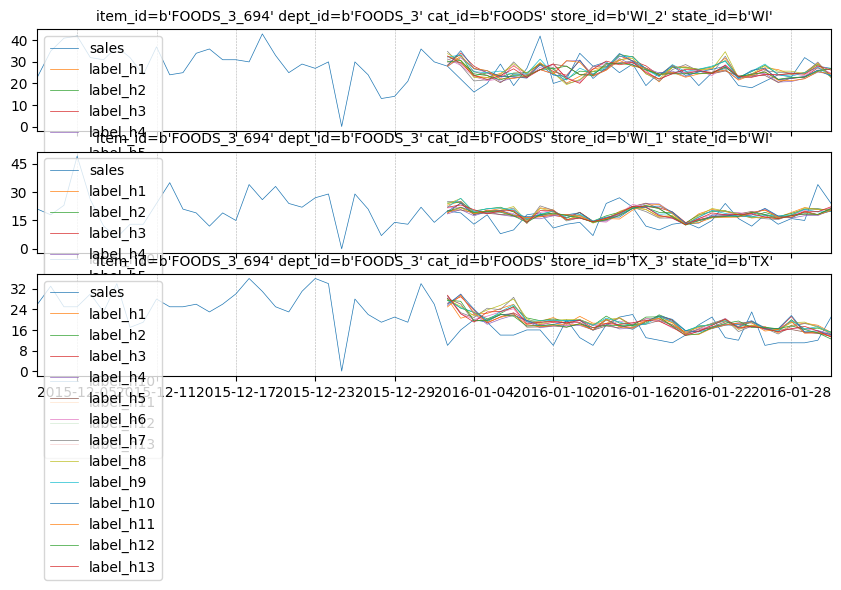

In [107]:
tp.plot([sales["sales"], predictions],
        max_num_plots=3,
        merge=True,    
        min_time= end_train_cutoff - timedelta(days=30),
        max_time= end_train_cutoff + timedelta(days=30),
)
# TODO: Remove legend.

This way of plotting predictions is not ideal (keep in mind that we are predicting future values).
Instead of plotting each prediction horizon separately, we want to plot all the predictions at a certain time.

In [123]:
predictions_at_point

timestamp,value
1.452e+09,5.948
1.452e+09,6.705
…,…
1.453e+09,10.84
1.453e+09,11.43
timestamp,value
1.452e+09,5.948
1.452e+09,6.705
…,…
1.453e+09,10.84


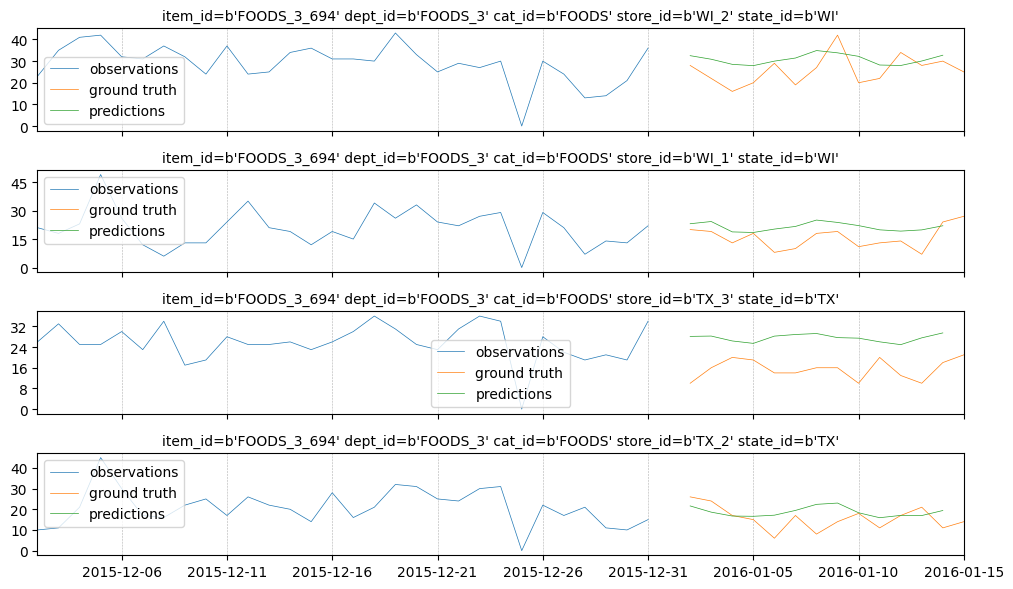

In [147]:
def compute_predictions_at_timepoint(predictions):
    index_names = test_examples.schema.index_names()
    rows = []
    for index_values, feature_values in predictions.data.items():
        
        # First prediction for each label
        values = [ feature[0] for feature in feature_values.features ]
        timestamps = map(datetime.utcfromtimestamp, feature_values.timestamps[:len(values)])
        # datetime.utcfromtimestamp(

        # TODO: use from_struct instead when available.
        # https://temporian.readthedocs.io/en/latest/reference/temporian/io/from_struct/
        index_map = { index_name:index_value for index_name, index_value in zip(index_names, index_values) }
        for value, timestamp in zip(values,timestamps):
            rows.append({"value": value, "timestamp": timestamp, **index_map})
        
    return tp.from_pandas(pd.DataFrame(rows), indexes = index_names)

predictions_at_point = compute_predictions_at_timepoint(predictions)

tp.plot([
    sales.before(end_train_cutoff).rename("observations"),
    sales.after(end_train_cutoff).rename("ground truth"),
    predictions_at_point.rename("predictions"),
],
        merge=True,
        max_num_plots=4,
        min_time= end_train_cutoff - timedelta(days=30),
        max_time= end_train_cutoff + timedelta(days=14),
       )

## More advanced features

Now that we have our setup in place, we can experiment with more advances feature engineering to improve our model power. We will generate the following features:

- Moving statistics: Aggregation of past values over a moving window such as moving sum, moving average, moving standard deviation.
- Calendar events: Access to special calendar events e.g. father's day.
- Calendar features: Human activities are strongly related to th day of the week (people don't have the same activity on monday that on sunday), day of the month and month of the day.
- Hierarchical aggregations: Aggregating values from related products e.g. products in the same departments or the same product in other stores.